# K-Mean Clustering

**Overview**<br>
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

We will be using the online reatil trasnational dataset to build a RFM clustering and choose the best set of customers.

In [1]:
#Importing Libraries
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Let's look at KMeans package help to better understand the KMeans implementation in Python using SKLearn

In [2]:
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
 |  
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose k observations (rows) at random from data for
 |      the initial centro

### Reading the Data Set

In [3]:
#reading Dataset
retail = pd.read_csv("Online+Retail.csv",  sep = ',', encoding = "ISO-8859-1", header= 0)
retail['InvoiceDate'] = retail['InvoiceDate'].str.replace('/', '-')
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

FileNotFoundError: File b'Online+Retail.csv' does not exist

### Data quality check and cleaning

In [ ]:
# Let's look top 5 rows
retail.head()

In [ ]:
#Sanity Check
retail.shape
retail.describe()
retail.info()

In [ ]:
#Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

In [ ]:
#dropping the na cells
order_wise = retail.dropna()

In [ ]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

### Extracting R(Recency), F(Frequency), M(Monetary) columns form the data that we imported in.

In [ ]:
#RFM implementation

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])
amount.head()

#### Monetary Value

In [ ]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

#Monetary Function
# Finding total amount spent per customer
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

#### If in the above result you get a column with name level_1, uncomment the below code and run it, else ignore it and keeping moving.

In [ ]:
#monetary.drop(['level_1'], axis = 1, inplace = True)
#monetary.head()

#### Frequency Value

In [ ]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [ ]:
# Getting the count of orders made by each customer based on customer ID.
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

##### Merging Amount and Frequency columns

In [ ]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

### Recency Value

In [ ]:
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)

In [ ]:
#Generating recency function

# Filtering data for customerid and invoice_date
recency  = order_wise[['CustomerID','InvoiceDate']]

# Finding max data
maximum = max(recency.InvoiceDate)

# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

In [ ]:
# recency by customerid
a = recency.groupby('CustomerID')

In [ ]:
a.diff.min()

In [ ]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

### RFM combined DataFrame

In [ ]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

### Outlier Treatment

In [ ]:
# outlier treatment for Amount
plt.figure(figsize=(15,25))
plt.subplot(121)
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]
plt.subplot(122)
plt.boxplot(RFM.Amount)

In [ ]:
print(Q1)
print(Q3)
print(Q1-(1.5*IQR))
print(Q3 + (1.5*IQR))

In [ ]:
# outlier treatment for Frequency
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]
plt.subplot(122)
plt.boxplot(RFM.Frequency)

In [ ]:
# outlier treatment for Recency
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]
plt.subplot(122)
plt.boxplot(RFM.Recency)

In [ ]:
RFM.head(20)

### Scaling the RFM data

In [ ]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [ ]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

Some usefull links to understand Hopkins Statistics:
- [WikiPedia](https://en.wikipedia.org/wiki/Hopkins_statistic)
- [Article](http://www.sthda.com/english/articles/29-cluster-validation-essentials/95-assessing-clustering-tendency-essentials/)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [ ]:
hopkins(RFM_norm1)

## K-Means with some K

In [ ]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [ ]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

In [ ]:
pd.DataFrame(sse_)

In [ ]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

## Sum of Squared Distances

In [ ]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [ ]:
print(ssd)

In [ ]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [ ]:
RFM_km.head()

In [ ]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


In [ ]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

<hr>

## Heirarchical Clustering

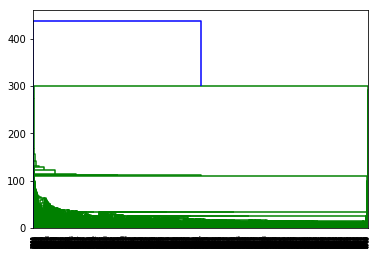

In [34]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

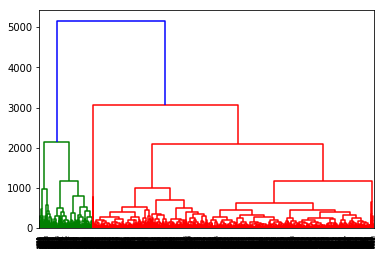

In [35]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [36]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

In [37]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [38]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,252.966698,22.707291,142.854733
1,1,1919.512313,92.709751,50.852608
2,2,867.327807,56.955626,73.369255
3,3,2990.865636,118.920530,44.165563
4,4,-1183.350000,7.800000,248.200000


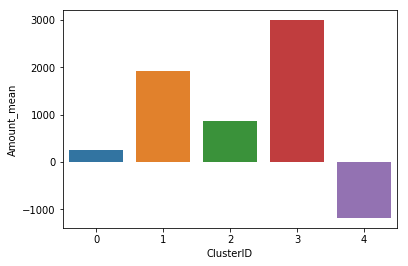

In [39]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

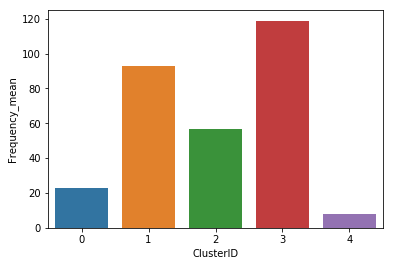

In [40]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

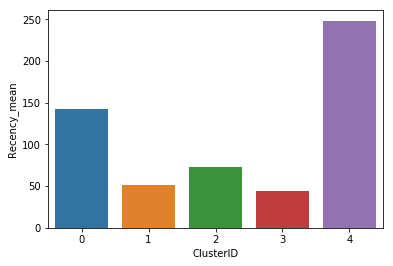

In [41]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)